<a href="https://colab.research.google.com/github/kscharpf/drl_intro/blob/master/DRLIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install gym

In [1]:
from collections import deque, namedtuple
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [2]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs, seed):
        super(DQN, self).__init__()
        print("h: {} w: {} outputs {}".format(h, w, outputs))
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(w,kernel_size=8,stride=4), kernel_size=4, stride=2)
        convh = conv2d_size_out(conv2d_size_out(h, kernel_size=8, stride=4), 
                                                kernel_size=4, stride=2)
        linear_input_size = convw * convh * 64
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128, outputs)
        

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
import random
BATCH_SIZE = 128
BUFFER_SIZE = int(2e5)
TAU = 0.01
GAMMA = 0.99
LR=1e-4
class DQNAgent:
    def __init__(self, height, width, action_size, seed):
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.batch_indices = torch.arange(BATCH_SIZE).long().to(device)
        self.samples_before_learning = 10000
        self.learn_interval = 20
        self.parameter_update_interval = 2
        self.tau = TAU
        self.gamma = GAMMA

        self.qnetwork_local = DQN(height, width, action_size, seed).to(device)
        self.qnetwork_target = DQN(height, width, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        self.t_step = 0
        
    def act(self, state, eps=0.):
    
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        state = state.reshape((1,state.shape[0], state.shape[1], state.shape[2]))
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() < eps:
            return random.choice(np.arange(self.action_size))
        else:
            return np.argmax(action_values.cpu().data.numpy())
        
    def step(self, state, action, reward, next_state, done):
        state = state.reshape((1,1,state.shape[0], state.shape[1]))
        next_state = next_state.reshape((1,1,next_state.shape[0], next_state.shape[1]))
        self.memory.add(state, action, reward, next_state, done)
        self.t_step += 1
        if self.t_step % self.learn_interval == 0:
            if len(self.memory) > self.samples_before_learning:
                #state = torch.from_numpy(state).float().unsqueeze(0).to(device)
                state = torch.from_numpy(state).float().to(device)

                #next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
                next_state = torch.from_numpy(next_state).float().to(device)

                target = self.qnetwork_local(state).data
                old_val = target[0][action]
                target_val = self.qnetwork_target(next_state).data
                if done:
                    target[0][action] = reward
                else:
                    target[0][action] = reward + self.gamma * torch.max(target_val)
                indices=None
                weights=None
                states, actions, rewards, next_states, dones = self.memory.sample()

                self.learn(states, actions, rewards, next_states, dones, indices, weights, self.gamma)
        
    def learn(self, states, actions, rewards, next_states, dones, indices, weights, gamma):
        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones)).float().to(device)
        states = states.reshape((BATCH_SIZE, 1, states.shape[1], states.shape[2]))
        next_states = next_states.reshape((BATCH_SIZE, 1, next_states.shape[1], next_states.shape[2]))

        Q_targets_next = self.qnetwork_target(next_states).detach()

        Q_targets_next = Q_targets_next.max(1)[0]

        Q_targets = rewards + gamma * Q_targets_next.reshape((BATCH_SIZE, 1)) * (1 - dones)

        pred = self.qnetwork_local(states)
        Q_expected = pred.gather(1, actions)

        self.optimizer.zero_grad()
        loss = F.mse_loss(Q_expected, Q_targets)
        loss.backward()
        self.optimizer.step()

        if self.t_step % self.parameter_update_interval == 0:
            self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def soft_update(self, qnetwork_local, qnetwork_target, tau):
        for local_param, target_param in zip(qnetwork_local.parameters(), qnetwork_target.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    

In [4]:
def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img))

In [7]:
import pickle
env = gym.make('BreakoutDeterministic-v4')
action_size = env.action_space.n
state = env.reset()
height, width = preprocess(state).shape
EPS_DECAY  = 0.99995
EPS_MIN = 0.05

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_episodes = 5000
agent = DQNAgent(height, width, action_size, 0)

scores = []
eps = 1.0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = preprocess(state)
    score = 0
    steps = 0
    while True:
        # Select and perform an action
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action.item())
        next_state = preprocess(next_state)
        reward = torch.tensor([reward], device=device)

        agent.step(state, action, reward, next_state, done)
        
        score += reward.cpu()[0]
        # Move to the next state
        state = next_state
        eps *= EPS_DECAY
        eps = max(eps, EPS_MIN)

        steps += 1
        if done:
            break
    if i_episode % 500 == 0:
      torch.save(agent.qnetwork_local.state_dict(), "breakout_{}.pt".format(i_episode))
      pickle.dump(scores, open("scores.pkl","wb"))
    scores.append(score)

    last20_mean = 0.
    last100_mean = 0.
    if i_episode > 20:
        last20_mean = np.mean(scores[i_episode-20:])
    if i_episode > 100:
        last100_mean = np.mean(scores[i_episode-100:])
    print("\rGame {:3d} Score {:.3f} completed in {:5d} steps eps {:.3f} last 20 avg {:.3f} last 100 avg {:.3f}".format(
        i_episode, score, steps, eps, last20_mean, last100_mean), end="")
    if i_episode % 20 == 0:
        print()

h: 105 w: 80 outputs 4
h: 105 w: 80 outputs 4
Game   0 Score 1.000 completed in   175 steps eps 0.991 last 20 avg 0.000 last 100 avg 0.000
Game  20 Score 1.000 completed in   191 steps eps 0.822 last 20 avg 0.000 last 100 avg 0.000
Game  40 Score 3.000 completed in   249 steps eps 0.683 last 20 avg 1.143 last 100 avg 0.000
Game  60 Score 2.000 completed in   209 steps eps 0.569 last 20 avg 1.143 last 100 avg 0.000
Game  80 Score 1.000 completed in   197 steps eps 0.466 last 20 avg 1.286 last 100 avg 0.000
Game 100 Score 2.000 completed in   204 steps eps 0.379 last 20 avg 1.714 last 100 avg 0.000
Game 120 Score 4.000 completed in   337 steps eps 0.305 last 20 avg 1.810 last 100 avg 1.396
Game 140 Score 3.000 completed in   268 steps eps 0.243 last 20 avg 2.143 last 100 avg 1.594
Game 160 Score 2.000 completed in   269 steps eps 0.197 last 20 avg 1.667 last 100 avg 1.693
Game 180 Score 0.000 completed in   141 steps eps 0.159 last 20 avg 1.810 last 100 avg 1.792
Game 200 Score 1.000 com

In [0]:
import seaborn as sns
import pandas as pd

In [0]:
  import torch
  torch.save(agent.qnetwork_local.state_dict(), "breakout_5000.pt") 


In [0]:
import pickle


In [0]:
import pandas as pd
smoothed_scores = np.array([np.mean(scores[max(i-100,0):i+1]) for i in range(4999)])
df = pd.DataFrame(smoothed_scores)

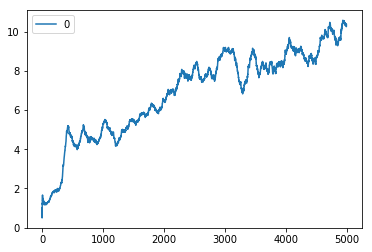

In [30]:
import seaborn as sns
sns.lineplot(data=df)

In [0]:
from google.colab import files

In [0]:
import torch
torch.save(agent.qnetwork_local.state_dict(), 'breakout.pt')

In [0]:
files.download('breakout_4000.pt')

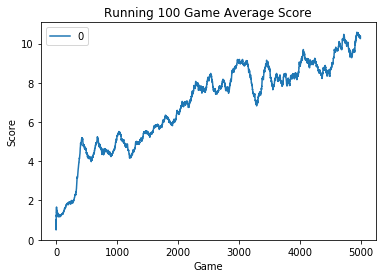

In [5]:
import seaborn as sns
import pandas as pd
import pickle as pkl
import numpy as np
scores = pkl.load(open('scores2.pkl','rb'))
smoothed_scores = np.array([np.mean(scores[max(i-100,0):i+1]) for i in range(4999)])
df = pd.DataFrame(smoothed_scores)
ax = sns.lineplot(data=df)
ax.set_title("Running 100 Game Average Score")
ax.set(xlabel='Game', ylabel='Score')
fig = ax.get_figure()
fig.savefig("average_scores.png")

In [0]:
import pickle as pkl
pkl.dump(scores, open('scores2.pkl','wb'))

In [0]:
files.download('scores2.pkl')

In [ ]:
import torch
import time

try:
    env
except:
    env = None
if env:
    env.close()
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()


scores = []
import gym
import time
env = gym.make("BreakoutDeterministic-v4")
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
action_size = env.action_space.n
height, width = preprocess(state).shape
agent = DQNAgent(height, width, action_size, 0)
agent.qnetwork_local.load_state_dict(torch.load('breakout_5000.pt'))
for game in range(1):
    done = False
    state = env.reset()
    state = preprocess(state)
    score = 0
    step = 0
    while not done:
        env.render()
        action = agent.act(state, 0.)
        next_state, reward, done, _ = env.step(action)
            
        state = preprocess(next_state)
        time.sleep(0.1)
        score += reward
        if done:
            break
        step += 1
    print("Game {:2d} Completed in {:4d} steps with score {}".format(game, step+1, score))
env.close()




h: 105 w: 80 outputs 4
h: 105 w: 80 outputs 4
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 0.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 1.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2.0
Score: 2

Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0
Score: 9.0

In [0]:
import pickle
env = gym.make('BreakoutDeterministic-v4')
action_size = env.action_space.n
state = env.reset()
height, width = preprocess(state).shape
EPS_DECAY  = 0.99995
EPS_MIN = 0.05

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_episodes = 5000
agent = DQNAgent(height, width, action_size, 0)

scores = []
eps = 1.0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = preprocess(state)
    score = 0
    steps = 0
    while True:
        # Select and perform an action
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action.item())
        next_state = preprocess(next_state)
        reward = torch.tensor([reward], device=device)

        agent.step(state, action, reward, next_state, done)
        
        score += reward.cpu()[0]
        # Move to the next state
        state = next_state
        eps *= EPS_DECAY
        eps = max(eps, EPS_MIN)

        steps += 1
        if done:
            break
    if i_episode % 500 == 0:
      torch.save(agent.qnetwork_local.state_dict(), "breakout_{}.pt".format(i_episode))
      pickle.dump(scores, open("scores.pkl","wb"))
    scores.append(score)

    last20_mean = 0.
    last100_mean = 0.
    if i_episode > 20:
        last20_mean = np.mean(scores[i_episode-20:])
    if i_episode > 100:
        last100_mean = np.mean(scores[i_episode-100:])
    print("\rGame {:3d} Score {:.3f} completed in {:5d} steps eps {:.3f} last 20 avg {:.3f} last 100 avg {:.3f}".format(
        i_episode, score, steps, eps, last20_mean, last100_mean), end="")
    if i_episode % 20 == 0:
        print()

h: 105 w: 80 outputs 4
h: 105 w: 80 outputs 4
Game   0 Score 1.000 completed in   175 steps eps 0.991 last 20 avg 0.000 last 100 avg 0.000
Game  20 Score 1.000 completed in   191 steps eps 0.822 last 20 avg 0.000 last 100 avg 0.000
Game  40 Score 3.000 completed in   249 steps eps 0.683 last 20 avg 1.143 last 100 avg 0.000
Game  60 Score 2.000 completed in   209 steps eps 0.569 last 20 avg 1.143 last 100 avg 0.000
Game  80 Score 1.000 completed in   197 steps eps 0.466 last 20 avg 1.286 last 100 avg 0.000
Game 100 Score 2.000 completed in   204 steps eps 0.379 last 20 avg 1.714 last 100 avg 0.000
Game 120 Score 4.000 completed in   337 steps eps 0.305 last 20 avg 1.810 last 100 avg 1.396
Game 140 Score 3.000 completed in   268 steps eps 0.243 last 20 avg 2.143 last 100 avg 1.594
Game 160 Score 2.000 completed in   269 steps eps 0.197 last 20 avg 1.667 last 100 avg 1.693
Game 180 Score 0.000 completed in   141 steps eps 0.159 last 20 avg 1.810 last 100 avg 1.792
Game 200 Score 1.000 com

In [6]:
import numpy as np

def layer(num_units):
    return np.random.rand(num_units)
def forward(w, x):
    return np.dot(w,x)

# model a linear equation Y=2x0 + 3x1
def truth(x):
    return np.array([2,3]).dot(x)

def train():
    layer1 = layer(2)
    layer2 = layer(1)
    
    in_x = np.array([8,5,10,1]).reshape((2,2))
    y_prime = np.array([layer2.dot(layer1.dot(in_x[0])), layer2.dot(layer1.dot(in_x[1]))])
    print(y_prime)
    print(truth(in_x))
                        
train()
                                                             
    


[[2.90508214]
 [0.87261576]]
[46 13]
